In [2]:
import torch
import sentencepiece as spm
import re
from transformer import Transformer
from encoder.encoder import Encoder
from decoder.decoder import Decoder
from utils.embedding_layer import EmbeddingLayer
from utils.positional_embedding import PositionalEmbedding
import numpy as np
from nltk.translate.bleu_score import sentence_bleu

test_data = np.load('test_data.npy', allow_pickle=True)
test_data = test_data.tolist()


# Define constants matching training
dim_model = 128
n_heads = 8
dim_ff = 1024
dropout = 0.1
vocab_size = 30000
n_encoder_layers = 5
n_decoder_layers = 5
max_len = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_by_length = {}
for en, hi in test_data:
    pos = en.index(2)
    if pos not in data_by_length:
        data_by_length[pos] = []
    data_by_length[pos].append([en, hi])

print(data_by_length[10][:3])

# Load the tokenizer
tokenizer = spm.SentencePieceProcessor()
tokenizer.load('en_hi.model')
# english = []
# hindi = []
# for en, hi in test_data:
#     english.append(en)
#     hindi.append(tokenizer.decode_ids(hi))

# Initialize model components
embedding_layer_encoder = EmbeddingLayer(vocab_size, dim_model, None, device)
embedding_layer_decoder = EmbeddingLayer(vocab_size, dim_model, None, device)
encoder = Encoder(dim_model, n_heads, dim_ff, n_encoder_layers, dropout, device)
decoder = Decoder(dim_model, n_heads, dim_ff, n_decoder_layers, dropout, device)
transformer = Transformer(encoder, decoder, dim_model, vocab_size, device)

# Load the saved model state
checkpoint = torch.load('translation_model_20.pth', map_location=device)
transformer.load_state_dict(checkpoint['transformer_state_dict'])
embedding_layer_encoder.load_state_dict(checkpoint['embedding_layer_encoder'])
embedding_layer_decoder.load_state_dict(checkpoint['embedding_layer_decoder'])

# Set the model to evaluation mode
transformer.eval()

bleu_avg_by_length={}

def beam_search_predict(eng_ids, max_len=32, beam_size=5, device='cpu'):
    # Encode source once
    src_tensor = torch.tensor([eng_ids], dtype=torch.long, device=device)
    enc = embedding_layer_encoder(src_tensor)
    pos = PositionalEmbedding(max_len, enc.size(-1), device).pe
    enc = enc + pos.expand_as(enc)
    
    # Initialize beam: list of (tokens, logprob)
    beams = [([tokenizer.bos_id()], 0.0)]
    
    for _ in range(max_len):
        all_candidates = []
        for seq, score in beams:
            if seq[-1] == tokenizer.eos_id():
                # already ended; carry forward unchanged
                all_candidates.append((seq, score))
                continue
            
            # Prepare decoder input
            dec_input = torch.tensor([seq], dtype=torch.long, device=device)
            dec_emb = embedding_layer_decoder(dec_input)
            dec_pos = pos[:, :len(seq), :].expand_as(dec_emb)
            dec_enc = dec_emb + dec_pos
            
            with torch.no_grad():
                logits = transformer(enc, dec_enc)[0, -1]  # (vocab,)
                log_probs = torch.log_softmax(logits, dim=-1)
            
            # Expand each beam
            topk_logps, topk_ids = log_probs.topk(beam_size)
            for logp, tok in zip(topk_logps.tolist(), topk_ids.tolist()):
                new_seq = seq + [tok]
                new_score = score + logp
                all_candidates.append((new_seq, new_score))
        
        # Keep top beam_size sequences
        beams = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam_size]
        # If all beams have ended, stop early
        if all(seq[-1] == tokenizer.eos_id() for seq, _ in beams):
            break
    
    # Return the highest‑scoring completed sequence (or partial if none ended)
    best_seq, best_score = max(beams, key=lambda x: x[1])
    # strip BOS and EOS
    result_ids = [tok for tok in best_seq if tok not in {tokenizer.bos_id(), tokenizer.eos_id()}]
    return result_ids

output_translations = []
#print(len(english))
print(data_by_length.keys())
for key,value in data_by_length.items():
    #if key in [9,23,31,14,13,15,17,12,20]:
    #    continue
    value=value[:10]
    bleu_total = 0
    print("-------------------------------------------------------------")
    print("Length: ", key)
    print("-------------------------------------------------------------")
    for i in range(len(value)):
        curr_english = value[i][0]
        curr_hindi = value[i][1]
        curr_hindi = curr_hindi[:curr_hindi.index(2)+1]
        curr_hindi = tokenizer.decode_ids(curr_hindi)
        translation = beam_search_predict(curr_english, max_len=32, beam_size=5, device=device)
        translation = tokenizer.decode_ids(translation)
        #output_translations.append(translation)
        bleu_score = sentence_bleu([curr_hindi],translation)
        print(bleu_score)
        bleu_total += bleu_score
    #print(bleu_total,len(value))
    print("Bleu Score: ", bleu_total/10)
    bleu_avg_by_length[key]=bleu_total/10


# for i in range(len(english)):
#     curr_english = english[i]
#     curr_hindi = hindi[i]
#     translation = predict(curr_english, max_len=32, device=device)
#     translation = tokenizer.decode_ids(translation)
#     output_translations.append(translation)
#     # print(translation)
#     # print(curr_hindi)
#     # print("-------------------------------------------------------------")
#     bleu_score = sentence_bleu([curr_hindi],translation)
#     print(bleu_score)
#     bleu_total += bleu_score
# print(bleu_total/len(english))

[[[1, 6011, 16296, 239, 29530, 2500, 1432, 3207, 31, 28389, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 2136, 1730, 198, 92, 2393, 17109, 1577, 29530, 304, 29530, 1141, 4323, 33, 29530, 9026, 39, 1036, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[1, 1578, 288, 624, 10163, 170, 116, 10163, 14, 9176, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 66, 475, 182, 195, 1103, 26856, 2517, 68, 721, 7309, 364, 29542, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[1, 162, 1269, 9788, 1176, 530, 57, 95, 28709, 9176, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 79, 2816, 7273, 15365, 3227, 1553, 749, 9176, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]]
dict_keys([9, 23, 10, 25, 31, 14, 24, 13, 16, 21, 11, 26, 15, 17, 12, 30, 22, 19, 20, 29, 27, 28, 18])
-------------------------------------------------------------
Length:  9
--------------------------------------------------

C:\Users\shubh\Desktop\NLP_Major\env\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


6.154849557015963e-155
0.6761539419239778
0.33595252887705757
0.2936888307190659
0.5583284542877519
0.18954952506770792
0.48091523486241544
0.5746199795091677
Bleu Score:  0.3845462371947874
-------------------------------------------------------------
Length:  10
-------------------------------------------------------------
1.7320458349246483e-78
0.428578104441349
2.9900029052376176e-78
0.6050585916158528
1.0
0.4471004168367317
0.15456387447015776
0.5817295586070355
3.0839145151269e-78
7.70649047396433e-155
Bleu Score:  0.3217030545971126
-------------------------------------------------------------
Length:  25
-------------------------------------------------------------
0.2817265921889336
0.027785678122425394
1.5553283585291135e-78
0.4670678731564325
0.3787829351075022
0.3436923342335809
0.4427223401948088
0.7107029420701755
0.5115383541131534
0.6961736582148174
Bleu Score:  0.38601927074018294
-------------------------------------------------------------
Length:  31
---------------

In [3]:
print(bleu_avg_by_length)

{9: 0.5050318639351095, 23: 0.3845462371947874, 10: 0.3217030545971126, 25: 0.38601927074018294, 31: 0.39633367093358973, 14: 0.48191033592173615, 24: 0.5218290191023185, 13: 0.4869924697905021, 16: 0.47069931685566385, 21: 0.49918212683268726, 11: 0.5049809523810328, 26: 0.44068245814071166, 15: 0.4862127876451271, 17: 0.45752590091102247, 12: 0.361265354638383, 30: 0.5546999684444704, 22: 0.4201741201946625, 19: 0.46691788014264857, 20: 0.5258523978976842, 29: 0.4131141705398263, 27: 0.4154944631140606, 28: 0.5251341533551424, 18: 0.3566057142703373}


In [18]:
bleu_avg_by_length = sorted(bleu_avg_by_length.items())
print(bleu_avg_by_length)

[(9, 0.5050318639351095), (10, 0.3217030545971126), (11, 0.5049809523810328), (12, 0.361265354638383), (13, 0.4869924697905021), (14, 0.48191033592173615), (15, 0.4862127876451271), (16, 0.47069931685566385), (17, 0.45752590091102247), (18, 0.3566057142703373), (19, 0.46691788014264857), (20, 0.5258523978976842), (21, 0.49918212683268726), (22, 0.4201741201946625), (23, 0.3845462371947874), (24, 0.5218290191023185), (25, 0.38601927074018294), (26, 0.44068245814071166), (27, 0.4154944631140606), (28, 0.5251341533551424), (29, 0.4131141705398263), (30, 0.5546999684444704), (31, 0.39633367093358973)]


In [19]:
lengthD = []
scoreD = []
for p in bleu_avg_by_length:
    lengthD.append(p[0])
    scoreD.append(p[1])

In [22]:
print(lengthD)

[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


In [20]:
print(scoreD)

[0.5050318639351095, 0.3217030545971126, 0.5049809523810328, 0.361265354638383, 0.4869924697905021, 0.48191033592173615, 0.4862127876451271, 0.47069931685566385, 0.45752590091102247, 0.3566057142703373, 0.46691788014264857, 0.5258523978976842, 0.49918212683268726, 0.4201741201946625, 0.3845462371947874, 0.5218290191023185, 0.38601927074018294, 0.44068245814071166, 0.4154944631140606, 0.5251341533551424, 0.4131141705398263, 0.5546999684444704, 0.39633367093358973]


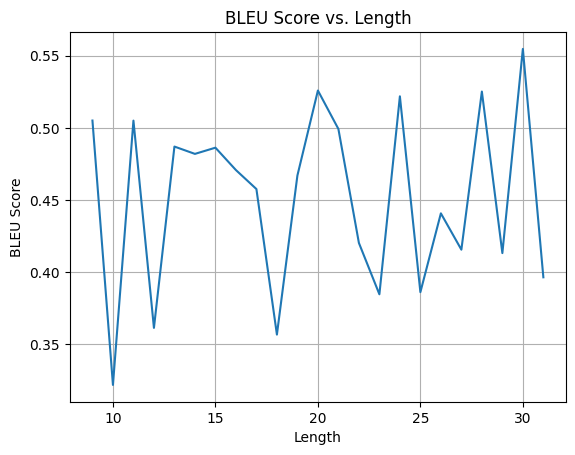

In [21]:
import matplotlib.pyplot as plt

plt.plot(lengthD, scoreD)
plt.xlabel("Length")
plt.ylabel("BLEU Score")
plt.title("BLEU Score vs. Length")
plt.grid(True)
plt.show()